## 03 – Transfer Learning (ResNet50, MobileNetV2, EfficientNetB0)

This notebook covers:

1. Environment & data pipeline setup  
2. Loading class weights (for imbalance handling)  
3. Transfer Learning with:
   - ResNet50
   - MobileNetV2
   - EfficientNetB0
4. Two-stage training (frozen base → fine-tuning)  
5. Evaluation on test set (metrics + confusion matrix)  
6. Saving best models + evaluation summaries

# Basic Imports

In [ ]:
# Import all required libraries for transfer learning, training and evaluation.

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Pretrained models
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0



## Mount Drive & Set Paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 # Define base project directories

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection"

REPORTS_DIR = os.path.join(BASE_DIR, "reports", "model_comparison")
MODELS_DIR = os.path.join(BASE_DIR, "models")
CLASSIFICATION_DIR = os.path.join(BASE_DIR, "data", "classification_dataset")

os.makedirs(REPORTS_DIR, exist_ok=True)

print("Base:", BASE_DIR)
print("Reports:", REPORTS_DIR)
print("Models:", MODELS_DIR)
print("Data:", DATA_DIR)

Base: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection
Reports: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/reports/model_comparison
Models: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models
Data: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/data/classification_dataset


## Recreate Data Generators

We keep the same:
- Image size: 224×224  
- Augmentations for train  
- Rescaling to [0, 1]  
So comparison with the custom CNN is fair.

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_dir = os.path.join(CLASSIFICATION_DIR, "train")
valid_dir   = os.path.join(CLASSIFICATION_DIR, "valid")
test_dir  = os.path.join(CLASSIFICATION_DIR, "test")

print("Train:", train_dir)
print("Valid:", valid_dir)
print("Test:", test_dir)

Train: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/data/classification_dataset/train
Valid: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/data/classification_dataset/valid
Test: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/data/classification_dataset/test


 Define ImageDataGenerators with augmentation for training

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

 Create train / val / test generators

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)

Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Class indices: {'bird': 0, 'drone': 1}


## 3. Load Class Weights (Saved from Previous Phase)

We reuse the same class weights so all models handle imbalance in the same way

In [ ]:
import json
from sklearn.utils.class_weight import compute_class_weight

weights_file = os.path.join(BASE_DIR, "config", "class_weights.json")

if os.path.exists(weights_file):
    # Load saved weights
    with open(weights_file, "r") as f:
        class_weights_dict = json.load(f)
    # JSON loads keys as strings → convert to int
    class_weights_dict = {int(k): float(v) for k, v in class_weights_dict.items()}
    print("✅ Loaded class weights from:", weights_file)
else:
    print("⚠️ class_weights.json not found — recomputing class weights.")

    labels = train_generator.classes  # 0 for bird, 1 for drone

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )

    class_weights_dict = dict(enumerate(class_weights))

    os.makedirs(os.path.join(BASE_DIR, "config"), exist_ok=True)
    with open(weights_file, "w") as f:
        json.dump(class_weights_dict, f, indent=4)

    print("✅ Computed and saved class weights to:", weights_file)

print("Final Class Weights:", class_weights_dict)

✅ Loaded class weights from: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/config/class_weights.json
Final Class Weights: {0: 0.9413012729844413, 1: 1.0665064102564104}


## 4. Common Utility Functions

We define helper functions to:
- Build transfer learning models
- Plot training curves
- Evaluate models and print/save metrics

In [ ]:
# Training history plotting utility

def plot_history(history, title_prefix=""):
    """Plot training and validation loss & accuracy curves."""
    hist = history.history

    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix} Training vs Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title_prefix} Training vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Evaluation utility – confusion matrix & classification report

In [ ]:
def evaluate_model(model, test_gen, model_name="model"):
    """Evaluate model on test set and print confusion matrix + classification report."""
    # Evaluate metrics directly
    print(f"\n🔹 Evaluating {model_name} on test set...")
    test_metrics = model.evaluate(test_gen, verbose=1)
    for name, value in zip(model.metrics_names, test_metrics):
        print(f"{name}: {value:.4f}")

    # Predictions for detailed analysis
    y_prob = model.predict(test_gen, verbose=1).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    y_true = test_gen.classes

    class_indices = test_gen.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    print("Class mapping:", inv_class_indices)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=[inv_class_indices[0], inv_class_indices[1]],
        yticklabels=[inv_class_indices[0], inv_class_indices[1]]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {model_name}")
    plt.tight_layout()
    plt.show()

    # Classification report
    report_str = classification_report(
        y_true, y_pred,
        target_names=[inv_class_indices[0], inv_class_indices[1]]
    )
    print("Classification Report:\n")
    print(report_str)

    # Numeric metrics summary
    report_dict = classification_report(
        y_true, y_pred,
        target_names=[inv_class_indices[0], inv_class_indices[1]],
        output_dict=True
    )
    overall_acc = accuracy_score(y_true, y_pred)

    bird = report_dict[inv_class_indices[0]]
    drone = report_dict[inv_class_indices[1]]
    weighted = report_dict['weighted avg']

    print("\n🔍 Detailed Evaluation Metrics")
    print("=======================================")
    print(f"✅ Overall Accuracy: {overall_acc:.4f}")
    print("---------------------------------------")
    print(f"🕊️ Bird Class (Label: {inv_class_indices[0]})")
    print(f"   Precision : {bird['precision']:.4f}")
    print(f"   Recall    : {bird['recall']:.4f}")
    print(f"   F1-Score  : {bird['f1-score']:.4f}")
    print("---------------------------------------")
    print(f"🚁 Drone Class (Label: {inv_class_indices[1]})")
    print(f"   Precision : {drone['precision']:.4f}")
    print(f"   Recall    : {drone['recall']:.4f}")
    print(f"   F1-Score  : {drone['f1-score']:.4f}")
    print("---------------------------------------")
    print(f"📊 Weighted Average (Overall)")
    print(f"   Precision : {weighted['precision']:.4f}")
    print(f"   Recall    : {weighted['recall']:.4f}")
    print(f"   F1-Score  : {weighted['f1-score']:.4f}")
    print("=======================================")

    # Return metrics for saving/comparison
    return {
        "overall_accuracy": overall_acc,
        "bird_precision": bird['precision'],
        "bird_recall": bird['recall'],
        "bird_f1": bird['f1-score'],
        "drone_precision": drone['precision'],
        "drone_recall": drone['recall'],
        "drone_f1": drone['f1-score'],
        "weighted_precision": weighted['precision'],
        "weighted_recall": weighted['recall'],
        "weighted_f1": weighted['f1-score'],
    }


## 5. Transfer Learning – Model Builder

We’ll use a common function `build_tl_model` that:
- Takes a pretrained base (ResNet50, MobileNetV2, EfficientNetB0)
- Freezes its layers
- Adds a custom classification head on top


Defining the Epochs for Stage 1 and Stage 2 Training

In [ ]:
EPOCHS_STAGE1 = 15
EPOCHS_STAGE2 = 30

In [ ]:
#  Generic transfer learning model builder

def build_tl_model(base_model, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """
    Wrap a pretrained base model with a custom classification head.
    Assumes base_model has include_top=False and appropriate input shape.
    """
    inputs = layers.Input(shape=input_shape)

    # The base model expects images in [0,1] (we already rescale) – ok for most Keras models.
    x = base_model(inputs, training=False)  # ensure base runs in inference mode while frozen

    # Global pooling + dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name=f"tl_{base_model.name.lower()}")
    return model


## ResNet50 – Training (Stage 1: Frozen, Stage 2: Fine-tune)

Building The Model

In [ ]:
# Build ResNet50-based model

# Load pretrained ResNet50 backbone without top classification layers
resnet_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze all layers for initial training stage
resnet_base.trainable = False

resnet_model = build_tl_model(resnet_base)
resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "tl_resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,281 (92.11 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Compiling The Model

In [ ]:
# Compile ResNet model (Stage 1)

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name="auc"),
]

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)


Callbacks

In [ ]:
# Callbacks for ResNet50

models_dir = os.path.join(BASE_DIR, "models")
os.makedirs(models_dir, exist_ok=True)

resnet_ckpt_path = os.path.join(models_dir, "resnet50_best.keras")

resnet_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

resnet_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

resnet_checkpoint = ModelCheckpoint(
    resnet_ckpt_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

resnet_callbacks = [resnet_early_stop, resnet_reduce_lr, resnet_checkpoint]


Training the Model - Stage 1

Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.5797 - auc: 0.6053 - loss: 0.6701 - precision: 0.5382 - recall: 0.4827
Epoch 1: val_loss improved from inf to 0.62984, saving model to /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models/resnet50_best.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.5796 - auc: 0.6053 - loss: 0.6701 - precision: 0.5383 - recall: 0.4833 - val_accuracy: 0.6290 - val_auc: 0.7085 - val_loss: 0.6298 - val_precision: 0.6502 - val_recall: 0.5867 - learning_rate: 0.0010
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.5916 - auc: 0.6259 - loss: 0.6596 - precision: 0.5677 - recall: 0.5087
Epoch 2: val_loss improved from 0.62984 to 0.62684, saving model to /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models/resnet50_best.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 53s 633ms/step - accuracy: 0.5915 - auc: 0.6258 - loss: 0.6596 - precision: 0.5677 - recall: 0.5087 - val_accur

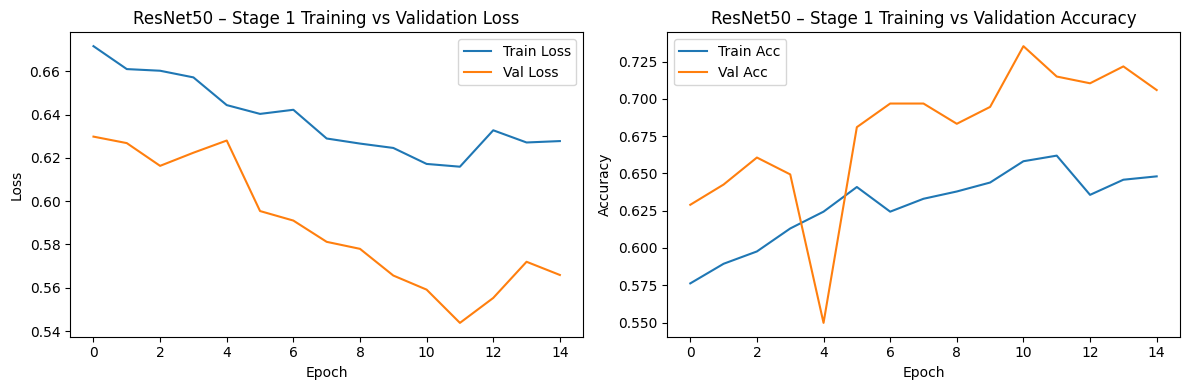

In [ ]:
# Train ResNet50 – Stage 1 (Frozen base)



history_resnet_stage1 = resnet_model.fit(
    train_generator,
    epochs=EPOCHS_STAGE1,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=resnet_callbacks
)

plot_history(history_resnet_stage1, title_prefix="ResNet50 – Stage 1")


Unfreezing Some Layers For Stage 2

In [ ]:
# Stage 2 – Unfreeze last few layers for fine-tuning

# Unfreeze some layers: here we unfreeze the last ~30 layers of the base model
resnet_base.trainable = True

for layer in resnet_base.layers[:-30]:
    layer.trainable = False

print("Number of trainable layers in ResNet base:",
      np.sum([layer.trainable for layer in resnet_base.layers]))

# Recompile with a lower learning rate for fine-tuning
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=METRICS
)


Number of trainable layers in ResNet base: 30


Training The Model - Stage 2

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.6511 - auc: 0.6996 - loss: 0.8917 - precision: 0.6567 - recall: 0.5913
Epoch 1: val_loss did not improve from 0.54375
84/84 ━━━━━━━━━━━━━━━━━━━━ 87s 762ms/step - accuracy: 0.6514 - auc: 0.6999 - loss: 0.8892 - precision: 0.6570 - recall: 0.5914 - val_accuracy: 0.5724 - val_auc: 0.8067 - val_loss: 0.6592 - val_precision: 1.0000 - val_recall: 0.1600 - learning_rate: 1.0000e-04
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.7022 - auc: 0.7663 - loss: 0.5657 - precision: 0.7332 - recall: 0.5760
Epoch 2: val_loss did not improve from 0.54375
84/84 ━━━━━━━━━━━━━━━━━━━━ 50s 590ms/step - accuracy: 0.7024 - auc: 0.7666 - loss: 0.5655 - precision: 0.7333 - recall: 0.5765 - val_accuracy: 0.6109 - val_auc: 0.8680 - val_loss: 0.6336 - val_precision: 0.9818 - val_recall: 0.2400 - learning_rate: 1.0000e-04
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.7300 - auc: 0.8136 - loss: 0.5249 - precision:

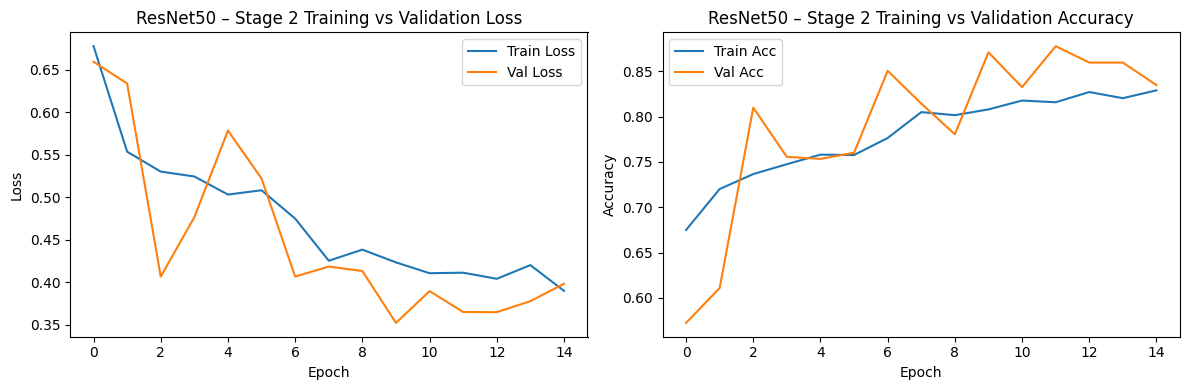

In [ ]:
# Train ResNet50 – Stage 2 (Fine-tuning)



history_resnet_stage2 = resnet_model.fit(
    train_generator,
    epochs=EPOCHS_STAGE2,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=resnet_callbacks   # still using same callbacks/checkpoint
)

plot_history(history_resnet_stage2, title_prefix="ResNet50 – Stage 2")


Evaluating The Test Set and Plotting The Confusion Matrix

✅ Loaded best ResNet50 weights from: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models/resnet50_best.keras

🔹 Evaluating ResNet50 on test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 129s 21s/step - accuracy: 0.8931 - auc: 0.5704 - loss: 0.3190 - precision: 0.4501 - recall: 0.4842
loss: 0.3456
compile_metrics: 0.8744
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 823ms/step
Class mapping: {0: 'bird', 1: 'drone'}


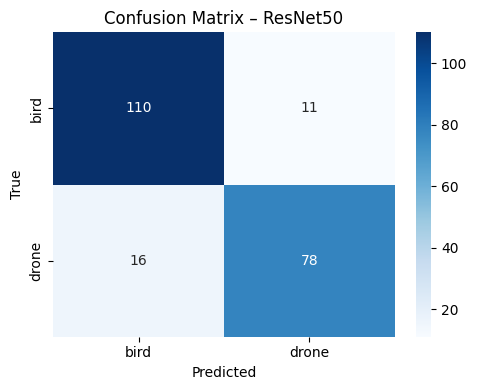

Classification Report:

              precision    recall  f1-score   support

        bird       0.87      0.91      0.89       121
       drone       0.88      0.83      0.85        94

    accuracy                           0.87       215
   macro avg       0.87      0.87      0.87       215
weighted avg       0.87      0.87      0.87       215


🔍 Detailed Evaluation Metrics
✅ Overall Accuracy: 0.8744
---------------------------------------
🕊️ Bird Class (Label: bird)
   Precision : 0.8730
   Recall    : 0.9091
   F1-Score  : 0.8907
---------------------------------------
🚁 Drone Class (Label: drone)
   Precision : 0.8764
   Recall    : 0.8298
   F1-Score  : 0.8525
---------------------------------------
📊 Weighted Average (Overall)
   Precision : 0.8745
   Recall    : 0.8744
   F1-Score  : 0.8740


In [ ]:
# Load best ResNet model and evaluate on test set

resnet_model.load_weights(resnet_ckpt_path)
print("✅ Loaded best ResNet50 weights from:", resnet_ckpt_path)

resnet_metrics = evaluate_model(resnet_model, test_generator, model_name="ResNet50")


## MobileNetV2 – Training (Frozen + Fine-tune)


Building The Model

In [ ]:
# Build MobileNetV2-based model

mobilenet_base = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

mobilenet_base.trainable = False

mobilenet_model = build_tl_model(mobilenet_base)
mobilenet_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "tl_mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,618,945 (9.99 MB)

 Trainable params: 360,961 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Compiling The Model

In [ ]:
# Compile MobileNetV2 model

mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)


Callbacks

In [ ]:
# Callbacks for MobileNetV2

mobilenet_ckpt_path = os.path.join(models_dir, "mobilenetv2_best.keras")

mobilenet_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

mobilenet_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

mobilenet_checkpoint = ModelCheckpoint(
    mobilenet_ckpt_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

mobilenet_callbacks = [mobilenet_early_stop, mobilenet_reduce_lr, mobilenet_checkpoint]


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.8374 - auc: 0.9126 - loss: 0.3987 - precision: 0.8171 - recall: 0.8276
Epoch 1: val_loss improved from inf to 0.08871, saving model to /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models/mobilenetv2_best.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 97s 935ms/step - accuracy: 0.8380 - auc: 0.9131 - loss: 0.3971 - precision: 0.8177 - recall: 0.8283 - val_accuracy: 0.9615 - val_auc: 0.9947 - val_loss: 0.0887 - val_precision: 0.9685 - val_recall: 0.9556 - learning_rate: 0.0010
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9441 - auc: 0.9835 - loss: 0.1548 - precision: 0.9440 - recall: 0.9367
Epoch 2: val_loss did not improve from 0.08871
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 586ms/step - accuracy: 0.9441 - auc: 0.9835 - loss: 0.1548 - precision: 0.9439 - recall: 0.9368 - val_accuracy: 0.9593 - val_auc: 0.9944 - val_loss: 0.0917 - val_precision: 0.9726 - val_recall: 0.9467 - learning_rate: 0.0010

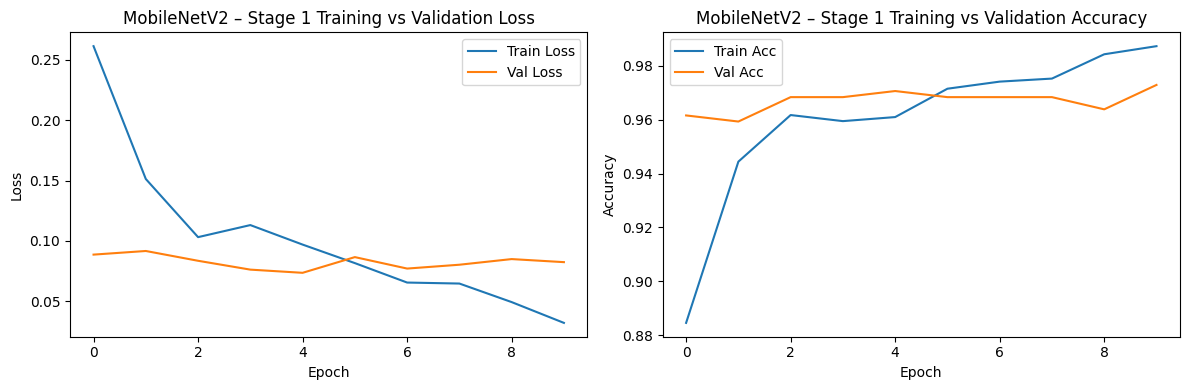

In [ ]:
# Train MobileNetV2 – Stage 1 (Frozen base)

history_mobilenet_stage1 = mobilenet_model.fit(
    train_generator,
    epochs=EPOCHS_STAGE1,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=mobilenet_callbacks
)

plot_history(history_mobilenet_stage1, title_prefix="MobileNetV2 – Stage 1")


Unfreezing some Layers for Stage 2

In [ ]:
# Fine-tune MobileNetV2 – unfreeze last few layers

mobilenet_base.trainable = True

for layer in mobilenet_base.layers[:-30]:
    layer.trainable = False

print("Trainable layers in MobileNetV2 base:",
      np.sum([layer.trainable for layer in mobilenet_base.layers]))

mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=METRICS
)


Trainable layers in MobileNetV2 base: 30


Training The Model for Stage 2

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9565 - auc: 0.9917 - loss: 0.1421 - precision: 0.9588 - recall: 0.9504
Epoch 1: val_loss improved from 0.07363 to 0.07130, saving model to /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models/mobilenetv2_best.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 755ms/step - accuracy: 0.9565 - auc: 0.9917 - loss: 0.1417 - precision: 0.9588 - recall: 0.9505 - val_accuracy: 0.9751 - val_auc: 0.9943 - val_loss: 0.0713 - val_precision: 0.9777 - val_recall: 0.9733 - learning_rate: 1.0000e-04
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.9773 - auc: 0.9966 - loss: 0.0679 - precision: 0.9788 - recall: 0.9749
Epoch 2: val_loss did not improve from 0.07130
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 573ms/step - accuracy: 0.9773 - auc: 0.9966 - loss: 0.0679 - precision: 0.9788 - recall: 0.9750 - val_accuracy: 0.9615 - val_auc: 0.9931 - val_loss: 0.1071 - val_precision: 0.9685 - val_recall: 0.9556 - learning_rate

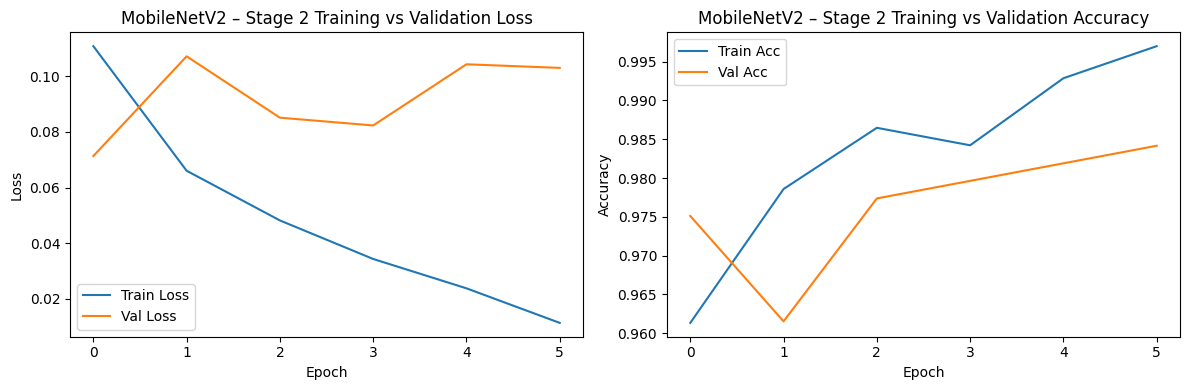

In [ ]:
# Train MobileNetV2 – Stage 2 (Fine-tuning)

history_mobilenet_stage2 = mobilenet_model.fit(
    train_generator,
    epochs=EPOCHS_STAGE2,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=mobilenet_callbacks
)

plot_history(history_mobilenet_stage2, title_prefix="MobileNetV2 – Stage 2")


Evaluating The Test Set and Plotting The Confusion Matrix

✅ Loaded best MobileNetV2 weights from: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models/mobilenetv2_best.keras

🔹 Evaluating MobileNetV2 on test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9818 - auc: 0.6230 - loss: 0.0442 - precision: 0.6016 - recall: 0.6044
loss: 0.0836
compile_metrics: 0.9767
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 776ms/step
Class mapping: {0: 'bird', 1: 'drone'}


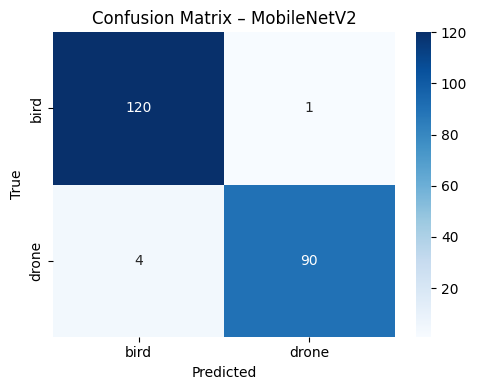

Classification Report:

              precision    recall  f1-score   support

        bird       0.97      0.99      0.98       121
       drone       0.99      0.96      0.97        94

    accuracy                           0.98       215
   macro avg       0.98      0.97      0.98       215
weighted avg       0.98      0.98      0.98       215


🔍 Detailed Evaluation Metrics
✅ Overall Accuracy: 0.9767
---------------------------------------
🕊️ Bird Class (Label: bird)
   Precision : 0.9677
   Recall    : 0.9917
   F1-Score  : 0.9796
---------------------------------------
🚁 Drone Class (Label: drone)
   Precision : 0.9890
   Recall    : 0.9574
   F1-Score  : 0.9730
---------------------------------------
📊 Weighted Average (Overall)
   Precision : 0.9770
   Recall    : 0.9767
   F1-Score  : 0.9767


In [ ]:
# Load best MobileNetV2 model and evaluate

mobilenet_model.load_weights(mobilenet_ckpt_path)
print("✅ Loaded best MobileNetV2 weights from:", mobilenet_ckpt_path)

mobilenet_metrics = evaluate_model(mobilenet_model, test_generator, model_name="MobileNetV2")


## 8. EfficientNetB0 – Training (Frozen + Fine-tune)


Generator for EfficientNetB0 Model, using different setting for this beacuse this model is very fragile and will perform very bad with same settings.

That's why we will be usng specific configuration for this model.

In [ ]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

IMG_SIZE = (224, 224)
BATCH_SIZE = 32   # change to 16 if OOM

# TRAIN
train_gen_e = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.20,
    horizontal_flip=True
).flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# VALIDATION (correct variable = val_dir)
val_gen_e = ImageDataGenerator(
    preprocessing_function=eff_preprocess
).flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# TEST
test_gen_e = ImageDataGenerator(
    preprocessing_function=eff_preprocess
).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Train samples:", train_gen_e.samples)
print("Val samples:", val_gen_e.samples)
print("Test samples:", test_gen_e.samples)
print("Class indices:", train_gen_e.class_indices)


Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Train samples: 2662
Val samples: 442
Test samples: 215
Class indices: {'bird': 0, 'drone': 1}


Building The Model With Specific Configurations

In [ ]:


# Load EfficientNetB0 backbone
eff_base = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Freeze base for Stage 1
eff_base.trainable = False

# Build classification head
inputs = layers.Input(shape=(224,224,3))

# IMPORTANT: use training=False to prevent batchnorm from updating in frozen mode
x = eff_base(inputs, training=False)

# Global pooling → best for transfer learning
x = layers.GlobalAveragePooling2D()(x)

# Recommended head for EfficientNet (stable & prevents collapse)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Output layer
outputs = layers.Dense(1, activation='sigmoid')(x)

# Build model
efficientnet_model = models.Model(inputs, outputs, name="EfficientNetB0_TL")

# Show summary
efficientnet_model.summary()

Model: "EfficientNetB0_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,410,532 (16.82 MB)

 Trainable params: 360,961 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Compiling the Model

In [ ]:
# ✅ Stable, EfficientNet-safe METRICS block
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name="auc"),
]

# ✅ STAGE-1 compile (Frozen base)
# LR = 1e-3 is normal, but 1e-4 is safer for unstable models
efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # safer LR
    loss='binary_crossentropy',
    metrics=METRICS
)

print("EfficientNet Stage-1 model compiled successfully.")


EfficientNet Stage-1 model compiled successfully.


Callback for EfficientNetB0 Model (Specific Callbacks)

In [ ]:


models_dir = os.path.join(BASE_DIR, "models")
os.makedirs(models_dir, exist_ok=True)

efficientnet_ckpt_path = os.path.join(models_dir, "efficientnetb0_best.keras")

# Early stopping — slightly more patient for EfficientNet (BatchNorm heavy)
efficientnet_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,                  # 5 → 6 (more stable)
    restore_best_weights=True
)

# Reduce LR on plateau — essential for EfficientNet
efficientnet_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6                 # 5e-6 → 1e-6 (crucial for fine-tuning)
)

# Save best model based on validation loss
efficientnet_checkpoint = ModelCheckpoint(
    efficientnet_ckpt_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

efficientnet_callbacks = [
    efficientnet_early_stop,
    efficientnet_reduce_lr,
    efficientnet_checkpoint
]

print("EfficientNet callbacks ready.")


EfficientNet callbacks ready.


Training the Model - Stage 1

In [ ]:
history_efficientnet_stage1 = efficientnet_model.fit(
    train_gen_e,
    epochs=EPOCHS_STAGE1,
    validation_data=val_gen_e,
    class_weight=class_weights_dict,
    callbacks=efficientnet_callbacks,
    verbose=1

)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.7495 - auc: 0.8313 - loss: 0.5258 - precision: 0.7129 - recall: 0.7943
Epoch 1: val_loss improved from inf to 0.18773, saving model to /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models/efficientnetb0_best.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 105s 939ms/step - accuracy: 0.7505 - auc: 0.8323 - loss: 0.5246 - precision: 0.7141 - recall: 0.7949 - val_accuracy: 0.9638 - val_auc: 0.9942 - val_loss: 0.1877 - val_precision: 0.9644 - val_recall: 0.9644 - learning_rate: 1.0000e-04
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9178 - auc: 0.9763 - loss: 0.2302 - precision: 0.9178 - recall: 0.9036
Epoch 2: val_loss improved from 0.18773 to 0.09995, saving model to /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models/efficientnetb0_best.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 521ms/step - accuracy: 0.9179 - auc: 0.9763 - loss: 0.2298 - precision: 0.9181 - recall:

Unfreezing Some layers for stage 2

In [ ]:
# Stage-2 Fine-Tuning for EfficientNetB0 (Correct & Stable)

# Unfreeze only the last 5 layers of EfficientNetB0
eff_base.trainable = True   # enable trainability first

# Freeze all layers except the last 5
for layer in eff_base.layers[:-5]:
    layer.trainable = False
for layer in eff_base.layers[-5:]:
    layer.trainable = True

print("Trainable EfficientNet base layers:",
      np.sum([layer.trainable for layer in eff_base.layers]))

# ✅ Recompile model with very small LR (EfficientNet requirement)
efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),   # 1e-5 → 5e-6 (safer)
    loss='binary_crossentropy',
    metrics=METRICS
)

print("EfficientNetB0 recompiled for Stage-2")


Trainable EfficientNet base layers: 5
EfficientNetB0 recompiled for Stage-2


Training the Model - Stage 2

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9745 - auc: 0.9973 - loss: 0.0934 - precision: 0.9900 - recall: 0.9572
Epoch 1: val_loss did not improve from 0.04568
84/84 ━━━━━━━━━━━━━━━━━━━━ 94s 816ms/step - accuracy: 0.9745 - auc: 0.9973 - loss: 0.0933 - precision: 0.9901 - recall: 0.9572 - val_accuracy: 0.9774 - val_auc: 0.9986 - val_loss: 0.0471 - val_precision: 0.9821 - val_recall: 0.9733 - learning_rate: 5.0000e-06
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9807 - auc: 0.9989 - loss: 0.0633 - precision: 0.9943 - recall: 0.9647
Epoch 2: val_loss did not improve from 0.04568
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 513ms/step - accuracy: 0.9807 - auc: 0.9989 - loss: 0.0633 - precision: 0.9942 - recall: 0.9647 - val_accuracy: 0.9774 - val_auc: 0.9987 - val_loss: 0.0485 - val_precision: 0.9821 - val_recall: 0.9733 - learning_rate: 5.0000e-06
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9788 - auc: 0.9977 - loss: 0.0686 - precision:

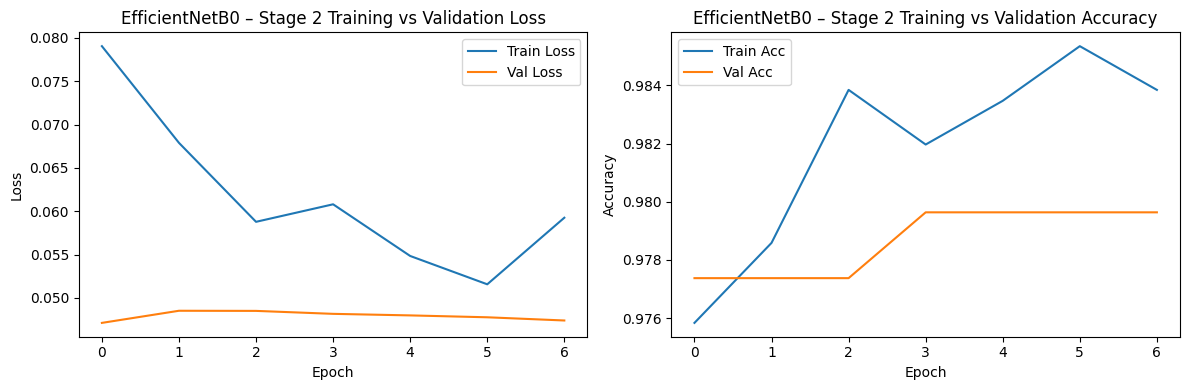

In [ ]:
# Train EfficientNetB0 – Stage 2 (Fine-tuning)

history_efficientnet_stage2 = efficientnet_model.fit(
    train_gen_e,
    epochs=EPOCHS_STAGE2,
    validation_data=val_gen_e,
    class_weight=class_weights_dict,
    callbacks=efficientnet_callbacks,
    verbose=1
)

plot_history(history_efficientnet_stage2, title_prefix="EfficientNetB0 – Stage 2")


Evaluating the Model for Test set and Plotting the Confusion martix

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Loaded best EfficientNetB0 weights from: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/models/efficientnetb0_best.keras

🔹 Evaluating EfficientNetB0 on test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9821 - auc: 0.6244 - loss: 0.0536 - precision: 0.5824 - recall: 0.6197
loss: 0.0581
compile_metrics: 0.9814


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Class mapping: {0: 'bird', 1: 'drone'}


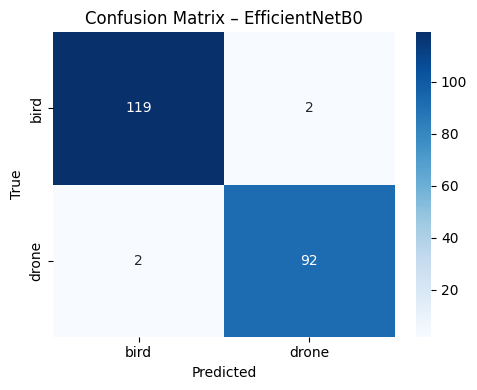

Classification Report:

              precision    recall  f1-score   support

        bird       0.98      0.98      0.98       121
       drone       0.98      0.98      0.98        94

    accuracy                           0.98       215
   macro avg       0.98      0.98      0.98       215
weighted avg       0.98      0.98      0.98       215


🔍 Detailed Evaluation Metrics
✅ Overall Accuracy: 0.9814
---------------------------------------
🕊️ Bird Class (Label: bird)
   Precision : 0.9835
   Recall    : 0.9835
   F1-Score  : 0.9835
---------------------------------------
🚁 Drone Class (Label: drone)
   Precision : 0.9787
   Recall    : 0.9787
   F1-Score  : 0.9787
---------------------------------------
📊 Weighted Average (Overall)
   Precision : 0.9814
   Recall    : 0.9814
   F1-Score  : 0.9814


In [ ]:
# ✅ Load best EfficientNetB0 model and evaluate (SIMPLE & CORRECT)

# 1. Load best weights
efficientnet_model.load_weights(efficientnet_ckpt_path)
print("✅ Loaded best EfficientNetB0 weights from:", efficientnet_ckpt_path)

# 2. Evaluate using the correct EfficientNet test generator (VERY IMPORTANT)
efficientnet_metrics = evaluate_model(
    efficientnet_model,
    test_gen_e,                 #  use EfficientNet-preprocessed test generator
    model_name="EfficientNetB0"
)


## 9. Saving alll Metrics for Model Comparison
We store metrics in a CSV so we can easily compare models later.


In [ ]:
import json
import os
import pandas as pd

def load_custom_cnn_metrics(json_path):
    """
    Load the JSON at json_path (expected structure is the one you pasted)
    and return a dict matching the required return format:
      {
        "overall_accuracy": ...,
        "bird_precision": ...,
        ...
      }
    """
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"JSON file not found: {json_path}")

    with open(json_path, "r") as f:
        raw = json.load(f)

    # Primary sources in your JSON
    test_metrics = raw.get("test_metrics", {})
    cr = raw.get("classification_report", {})

    # Grab per-class dicts
    bird = cr.get("bird", {})
    drone = cr.get("drone", {})

    # weighted avg key in your JSON is "weighted avg"
    weighted = cr.get("weighted avg", cr.get("weighted_avg", cr.get("weighted", {})))

    # overall accuracy: prefer test_metrics['accuracy'] but fall back to classification_report['accuracy']
    overall_acc = test_metrics.get("accuracy", cr.get("accuracy"))

    # Build result dict exactly as you requested
    result = {
        "overall_accuracy": overall_acc,
        "bird_precision": bird.get("precision"),
        "bird_recall": bird.get("recall"),
        "bird_f1": bird.get("f1-score"),
        "drone_precision": drone.get("precision"),
        "drone_recall": drone.get("recall"),
        "drone_f1": drone.get("f1-score"),
        "weighted_precision": weighted.get("precision"),
        "weighted_recall": weighted.get("recall"),
        "weighted_f1": weighted.get("f1-score"),
    }
    return result

# --------- USAGE ---------
# set this to your actual JSON path; common: os.path.join(REPORTS_DIR, "custom_cnn_metrics.json")
custom_json_path = os.path.join(REPORTS_DIR, "custom_cnn_metrics.json")

custom_cnn_metrics = load_custom_cnn_metrics(custom_json_path)
print("Extracted metrics:", custom_cnn_metrics)

# Now create / update the DataFrame and save CSV
metrics_df = pd.DataFrame([
    {"model": "Custom_CNN", **custom_cnn_metrics},
    {"model": "ResNet50", **resnet_metrics},
    {"model": "MobileNetV2", **mobilenet_metrics},
    {"model": "EfficientNetB0", **efficientnet_metrics},
])

metrics_csv_path = os.path.join(reports_dir, "transfer_learning_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print("✅ Metrics saved to:", metrics_csv_path)
metrics_df


Extracted metrics: {'overall_accuracy': 0.8930232524871826, 'bird_precision': 0.8769230769230769, 'bird_recall': 0.9421487603305785, 'bird_f1': 0.9083665338645418, 'drone_precision': 0.9176470588235294, 'drone_recall': 0.8297872340425532, 'drone_f1': 0.8715083798882681, 'weighted_precision': 0.8947279806376933, 'weighted_recall': 0.8930232558139535, 'weighted_f1': 0.8922518060795663}
✅ Metrics saved to: /content/drive/MyDrive/Project-2/Aerial_Object_Classification_&_Detection/reports/model_comparison/transfer_learning_metrics.csv


,model,overall_accuracy,bird_precision,bird_recall,bird_f1,drone_precision,drone_recall,drone_f1,weighted_precision,weighted_recall,weighted_f1
0,Custom_CNN,0.893023,0.876923,0.942149,0.908367,0.917647,0.829787,0.871508,0.894728,0.893023,0.892252
1,ResNet50,0.874419,0.873016,0.909091,0.890688,0.876404,0.829787,0.852459,0.874497,0.874419,0.873974
2,MobileNetV2,0.976744,0.967742,0.991736,0.979592,0.989011,0.957447,0.972973,0.977041,0.976744,0.976698
3,EfficientNetB0,0.981395,0.983471,0.983471,0.983471,0.978723,0.978723,0.978723,0.981395,0.981395,0.981395
